# Описание проекта

Клиентам компании «Мегалайн» предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В исследовании предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше, т.е. приносит больше прибыли.

**Описание тарифов**
- Тариф «Смарт»
  - Ежемесячная плата: 550 рублей
  - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
  - Стоимость услуг сверх тарифного пакета:
  - минута разговора: 3 рубля
  - сообщение: 3 рубля
  - 1 Гб интернет-трафика: 200 рублей

- Тариф «Ультра»
  - Ежемесячная плата: 1950 рублей
  - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
  - Стоимость услуг сверх тарифного пакета:
  - минута разговора: 1 рубль
  - сообщение: 1 рубль
  - 1 Гб интернет-трафика: 150 рублей

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Загрузка файлов с данными и изучение общей информации

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import os
from IPython.display import display

### Загрузка данных

In [2]:
if os.path.exists('datasets/calls.csv'):
    calls = pd.read_csv('datasets/calls.csv')
    internet = pd.read_csv('datasets/internet.csv')
    messages = pd.read_csv('datasets/messages.csv')
    tariffs = pd.read_csv('datasets/tariffs.csv')
    users = pd.read_csv('datasets/users.csv')

else:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
    

### Общая информация `calls`

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Для упрощения вывода общей информации напишем функцию

In [3]:
def show_info(table):
    display(table.head())
    display(table.describe())
    print(table.info())

In [4]:
show_info(calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


Вывод: пропущенных данных нет, расброс значений `duration`(0...38) и `user_id`(1000...1499)  не выходит за рамки разумных, формат столбца `call_date` необходимо будет привести к *datatime*, столбец `id` переименовать в `calls_id`.

### Общая информация `internet`

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [5]:
show_info(internet)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


Вывод: пропущенных данных нет, расброс значений `mb_used`(0...1724) и `user_id`(1000...1499)  не выходит за рамки разумных, формат столбца `session_date` необходимо будет привести к *datatime*, столбец `Unnamed: 0` нужно удалить, как неинформативный, столбец `id` переименовать в `internet_id`.

### Общая информация `messages`

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [6]:
show_info(messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


Вывод: пропусков не обнаружено, формат столбца `message_date` необходимо будет привести к *datatime*, столбец `id` переименовать в `message_id`.

### Общая информация `tariffs`

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора - в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [7]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Вывод: таблица несет чисто информационный характер.

### Общая информация `users`

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [8]:
show_info(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


Вывод: пропуски имеются только в столбце `churn_date`,скорее всего они являются свидетельством активности тарифа(т.е. нет даты его закрытия), разброс значений возраста `age`(18...75) в пределах разумного, формат столбцов `reg_date` и `churn_date` необходимо будет привести к *datatime*, столбцы `first_name` и `last_name` удалить, как неинформативные.

### Вывод

Данные успешно загружены, получена общая информация о данных, намечены необходимые преобразования для дальнейшей работы.

## Подготовка данных

### Приведение данных к нужным типам

In [9]:
# заменяем типы данных
calls['call_date'] = pd.to_datetime(calls['call_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])


In [10]:
# проверим успешность замены типов
for df in [calls, users, messages, internet]:
    df.info()
    print()
    print('x-'*20)
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB

x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    objec

### Удаление ненужных столбцов

In [11]:
# удаляем столбец "Unnamed: 0" в internet
internet = internet.drop(['Unnamed: 0'], axis=1)

# удаляем столбцы "first_name" и "last_name" в users
users = users.drop(['first_name', 'last_name'], axis=1)

In [12]:
# проверяем результат удаления
display(internet.head()), display(users.head())

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,user_id,age,churn_date,city,reg_date,tariff
0,1000,52,NaT,Краснодар,2018-05-25,ultra
1,1001,41,NaT,Москва,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,2018-06-17,smart
3,1003,23,NaT,Москва,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,2018-05-14,ultra


(None, None)

Вывод: лишние столбцы удалены

### Поиск и устранение аномалий в данных

#### Таблица  `calls`

In [13]:
calls.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,202607,202607,1056_280,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
call_date,202607,NaN,NaN,NaN,2018-09-02 20:01:37.583992832,2018-01-01 00:00:00,2018-07-05 00:00:00,2018-09-17 00:00:00,2018-11-14 00:00:00,2018-12-31 00:00:00,NaN
duration,202607.0,NaN,NaN,NaN,6.755887,0.0,1.3,6.0,10.7,38.0,5.843365
user_id,202607.0,NaN,NaN,NaN,1253.940619,1000.0,1126.0,1260.0,1379.0,1499.0,144.722751


Количество id  совпадает с числом уникальных значений, значит дубликатов нет.

In [14]:
# число уникальных дат
len(calls.call_date.unique())

365

Число уникальных дней совпадает с числом дней в году. 

In [15]:
# число уникальных пользователей
len(calls.user_id.unique())

492

То есть 8 человек (500 - 492) не совершали звонков. Взглянем на данные этих людей.

In [16]:
# соберем id_user незвонящих клиентов в список not_calls_id  
not_calls_id = []

for i in range(1000, 1500):
    if i not in calls.user_id.unique():
        not_calls_id.append(i)
not_calls_id

[1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489]

In [17]:
# список незвонящих клиентов
users.query('user_id in @not_calls_id')

,user_id,age,churn_date,city,reg_date,tariff
91,1091,36,NaT,Набережные Челны,2018-05-08,ultra
106,1106,67,NaT,Калуга,2018-04-26,ultra
128,1128,51,2018-12-23,Волжский,2018-12-15,ultra
231,1231,63,NaT,Чебоксары,2018-05-23,ultra
328,1328,44,NaT,Мурманск,2018-10-16,ultra
371,1371,50,2018-12-30,Омск,2018-12-25,smart
473,1473,18,NaT,Красноярск,2018-08-05,ultra
489,1489,35,NaT,Санкт-Петербург,2018-08-15,smart


Ничего необычного, кроме того, что клиенты с `user_id` 1128 и 1371 закрыли(сменили) тариф примерно через неделю после регистрации, так и не успев сделать ни одного звонка. Возможно, остальным сим-карта нужна только для доступа к интернет. Проверим.

In [18]:
# узнаем годовой трафик этих клиентов
internet.query('user_id in @not_calls_id').groupby('user_id').mb_used.sum()

user_id
1091    107404.96
1106    156163.90
1231    222528.37
1328     97373.29
1473     83975.96
1489     82630.37
Name: mb_used, dtype: float64

Так и есть, эти клиенты активные пользователь интернет.

Столбец `call_date` все даты вкладываются в диапазон 01.01.2018...12.31.2018. 

Столбец `duration` рассмотрим подробнее.

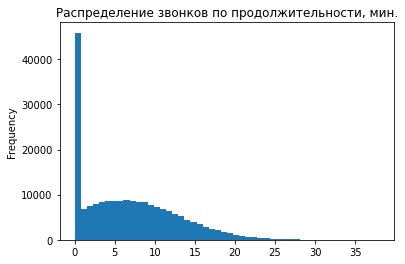

In [19]:
calls.duration.plot(kind='hist', bins=50, title='Распределение звонков по продолжительности, мин.')
plt.show()

Звонки с нулевой длительностью - пропущенные звонки, они денег не приносят, но и удалять их не будем, посмотрим на распределение без них.

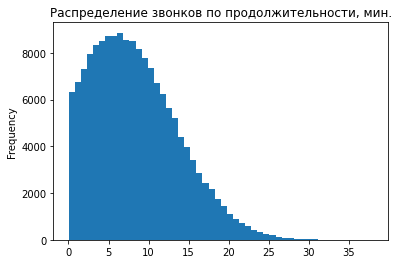

In [20]:
calls.query("duration > 0").duration.plot(kind='hist', bins=50, title='Распределение звонков по продолжительности, мин.')
plt.show()

Видим классическое распределение Пуассона, самые частые звонки около 7-8 минут, число звонков длительностью более 25 минут ничтожно мало.

In [21]:
# переименование столбца
calls.rename(columns={'id': 'calls_id'}, inplace=True)

**Вывод.** Данные в таблице `calls` корректны.

#### Таблица `internet`

In [22]:
internet.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,149396,149396,1443_116,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mb_used,149396.0,NaN,NaN,NaN,370.192426,0.0,138.1875,348.015,559.5525,1724.83,278.300951
session_date,149396,NaN,NaN,NaN,2018-09-02 12:55:35.221826560,2018-01-01 00:00:00,2018-07-05 00:00:00,2018-09-17 00:00:00,2018-11-14 00:00:00,2018-12-31 00:00:00,NaN
user_id,149396.0,NaN,NaN,NaN,1252.099842,1000.0,1130.0,1251.0,1380.0,1499.0,144.050823


Количество id  совпадает с числом уникальных значений, значит дубликатов нет.

In [23]:
# число уникальных дат
len(internet.session_date.unique())

365

С датами все в порядке.

In [24]:
# число уникальных пользователей
len(internet.user_id.unique())

497

Три клиента не пользуются интернет. Посмотрим на них.

In [25]:
# соберем id_user клиентов без траффика в список not_internet_id  
not_internet_id = []

for i in range(1000, 1500):
    if i not in internet.user_id.unique():
        not_internet_id.append(i)
not_internet_id

[1128, 1273, 1371]

In [26]:
# список  клиентов без траффика
users.query('user_id in @not_internet_id')

,user_id,age,churn_date,city,reg_date,tariff
128,1128,51,2018-12-23,Волжский,2018-12-15,ultra
273,1273,46,NaT,Курган,2018-05-15,ultra
371,1371,50,2018-12-30,Омск,2018-12-25,smart


Два клиента с id_user 1128 и 1371 сменили или закрыли тариф в течении недели. Посмотрим на активность клиента id_user 1273 по звонкам и сообщениям.

In [27]:
# число сообщений в течении года
messages.query('user_id == 1273').id.count()

272

In [28]:
# количество минут
calls.query('user_id == 1273').duration.agg(['sum', 'count'])

sum      1894.2
count     320.0
Name: duration, dtype: float64

Скорее всего у этого клиента не смартфон, он использует лишь звонки и смс.

In [29]:
# переименование столбца
internet.rename(columns={'id': 'internet_id'}, inplace=True)


<font color='Blue'><b>Распределение данных в столбце `internet`</b></font><br>

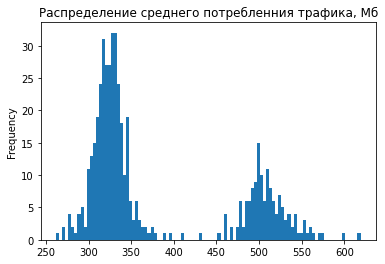

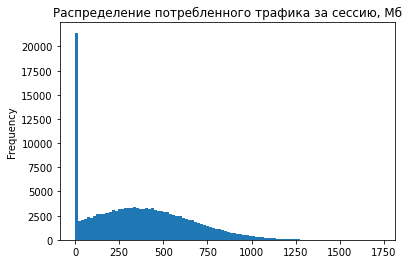

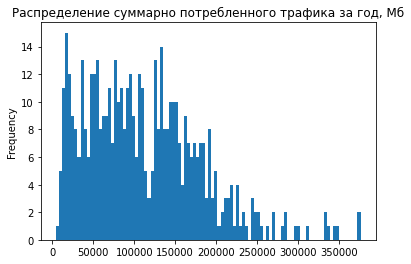

In [30]:
(internet.groupby('user_id')['mb_used'].mean()
     .plot(kind='hist',
           bins=100,
           title='Распределение среднего потребленния трафика, Мб')
)
plt.show()
(internet.groupby('internet_id')['mb_used'].sum()
     .plot(kind='hist',
           bins=100,
           title='Распределение потребленного трафика за сессию, Мб')
)
plt.show()
(internet.groupby('user_id')['mb_used'].sum()
     .plot(kind='hist',
           bins=100,
           title='Распределение суммарно потребленного трафика за год, Мб')
)
plt.show()

In [31]:
# количество записей с 0 трафиком
internet.query('mb_used == 0')['mb_used'].count()

19598

Наблюдается бимодальное распределение по среднему потреблению трафика пользователем. Такое бывает. Еще мы видим большое число подключений с 0 трафиком (19598). Возможная причина - частые переподключения из-за сбоев в сети, и как следствие короткие сессии без трафика.

Чтобы уменьшить количество обрабатываемых записей без потери качества данных, можем удалить значения с 0 трафиком. Еще и ресурсы сэкономим.

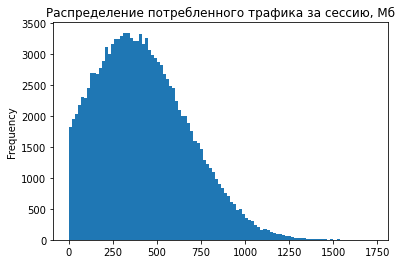

In [32]:
internet = internet.query('mb_used > 0')
(internet.groupby('internet_id')['mb_used'].sum()
     .plot(kind='hist',
           bins=100,
           title='Распределение потребленного трафика за сессию, Мб')
)
plt.show()

Теперь мы наблюдаем классическое распределение Пуассона.

**Вывод.** Данные в таблице `internet` корректны.

####  Таблица `messages`

In [33]:
messages.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,123036,123036,1465_165,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
message_date,123036,NaN,NaN,NaN,2018-09-04 15:28:42.227640576,2018-01-02 00:00:00,2018-07-09 00:00:00,2018-09-20 00:00:00,2018-11-14 00:00:00,2018-12-31 00:00:00,NaN
user_id,123036.0,NaN,NaN,NaN,1256.98941,1000.0,1134.0,1271.0,1381.0,1499.0,143.523967


Количество id совпадает с числом уникальных значений, значит дубликатов нет.

In [34]:
# число уникальных дат
len(messages.message_date.unique())

364

Сообщения начинают отправляться с 02.01.2018. Возможно сеть была перегружена 01.01 поздравлениями с Новым годом и сообщения не отправлялись.

In [35]:
# число уникальных пользователей
len(messages.user_id.unique())

426

Не все пользователь отправляют сообщения. Кому что удобней.

In [36]:
# переименование столбца
messages.rename(columns={'id': 'messages_id'}, inplace=True)

**Вывод.** Данные в таблице `messages` корректны.

####  Таблица `users`

In [37]:
users.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,500.0,NaN,NaN,NaN,1249.5,1000.0,1124.75,1249.5,1374.25,1499.0,144.481833
age,500.0,NaN,NaN,NaN,46.588,18.0,32.0,46.0,62.0,75.0,16.66763
churn_date,38,NaN,NaN,NaN,2018-11-13 00:37:53.684210432,2018-08-17 00:00:00,2018-10-14 00:00:00,2018-11-24 00:00:00,2018-12-15 12:00:00,2018-12-30 00:00:00,NaN
city,500,76,Москва,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reg_date,500,NaN,NaN,NaN,2018-06-30 18:57:35.999999744,2018-01-01 00:00:00,2018-04-07 12:00:00,2018-07-02 12:00:00,2018-09-29 00:00:00,2018-12-31 00:00:00,NaN
tariff,500,2,smart,351,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# число уникальных пользователей
len(users.user_id.unique())

500

In [39]:
# посмотрим на распределение значения tariff
users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

- Число уникальных пользователей `user_id` совпадает с их общим числом *count*, значит дубликатов нет. 
- Колонка `age` - заполнены все 500 значений, параметры возраста соответствуют действительным: от 18 до 75 лет.
- Колонка `churn_date` - заполнены 38 значений из 500, это говорит о том, что только 38 клиентов закрыли тариф в исследуемом году, а остальные продолжают им пользоваться.
- Колонка `city` заполнены все 500 значений, среди них уникальных - 76. *Москва* лидирует по количеству клиентов, их 99.
- Колонка `tariff` имеет всего два уникальных значения, что логично, заполнены все 500 значений. Однако, **распределение клиентов неравномерно**, отличается более чем в 2 раза, что может сказаться на оценке суммарных показателей тарифов.

In [40]:
# посмотрим на уникальные значения age
users.age.unique()

array([52, 41, 59, 23, 68, 67, 21, 65, 63, 24, 26, 44, 38, 36, 64, 58, 73,
       71, 61, 72, 42, 56, 32, 62, 20, 51, 28, 66, 31, 37, 47, 40, 69, 48,
       33, 39, 43, 46, 45, 55, 53, 34, 49, 25, 18, 70, 50, 19, 54, 60, 29,
       27, 74, 22, 30, 75, 57, 35])

In [41]:
# посмотрим на уникальные значения city
sorted(users.city.unique())

['Архангельск',
 'Астрахань',
 'Балашиха',
 'Барнаул',
 'Белгород',
 'Брянск',
 'Владивосток',
 'Владикавказ',
 'Владимир',
 'Волгоград',
 'Волжский',
 'Вологда',
 'Воронеж',
 'Грозный',
 'Екатеринбург',
 'Иваново',
 'Ижевск',
 'Иркутск',
 'Казань',
 'Калининград',
 'Калуга',
 'Кемерово',
 'Киров',
 'Кострома',
 'Краснодар',
 'Красноярск',
 'Курган',
 'Курск',
 'Липецк',
 'Магнитогорск',
 'Махачкала',
 'Москва',
 'Мурманск',
 'Набережные Челны',
 'Нижневартовск',
 'Нижний Новгород',
 'Нижний Тагил',
 'Новокузнецк',
 'Новороссийск',
 'Новосибирск',
 'Омск',
 'Оренбург',
 'Орёл',
 'Пенза',
 'Пермь',
 'Петрозаводск',
 'Подольск',
 'Ростов-на-Дону',
 'Рязань',
 'Самара',
 'Санкт-Петербург',
 'Саранск',
 'Саратов',
 'Севастополь',
 'Смоленск',
 'Сочи',
 'Ставрополь',
 'Стерлитамак',
 'Сургут',
 'Тамбов',
 'Тверь',
 'Тольятти',
 'Томск',
 'Тула',
 'Тюмень',
 'Улан-Удэ',
 'Ульяновск',
 'Уфа',
 'Хабаровск',
 'Химки',
 'Чебоксары',
 'Челябинск',
 'Череповец',
 'Чита',
 'Якутск',
 'Ярославль']

Неявных дубликатов и аномалий не выявлено.


**Вывод.** Данные в таблице `users` корректны.

#### Таблица `tariffs`

In [42]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Для удобства рассчетов переведем значение мегабайт в гигабайты.

In [43]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs = tariffs.rename(columns={'mb_per_month_included':'gb_per_month_included'})
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


Вывод. Данные в таблице `tariffs` корректны.

#### Проверка дубликатов

In [44]:
# без аттрибута name не хотят выводить на печать название таблицы
calls.name = 'calls'
users.name = 'users'
messages.name = 'messages'
internet.name = 'internet'

tables = [calls, users, messages, internet]
for df in tables:
    print(f'Дубликатов в {df.name}: {df.duplicated().sum()}')


Дубликатов в calls: 0
Дубликатов в users: 0
Дубликатов в messages: 0
Дубликатов в internet: 0


Вывод. Дубликатов в таблицах нет.

### Вывод. 
В процессе подготовки данные были проверены на наличие пропусков, аномальных значений, выбросов. Изъяны обнаружены не были, это говорит о хорошем качестве данных. Удалены лишние неинформативные столбцы. Удалены баластные данные по двум клиентам, которые фактически не пользовались тарифом. Столбцы, содержащие даты приведены к типу **datetime**

## Расчет показателей для каждого клиента.

### Создание дополнительных столбцов.

Для группировки и подсчета помесячных показателей создадим дополнительные столбцы с указанием месяца для трех таблиц: `calls`, `messages` и `internet`.

In [45]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month
display(calls.head(3), messages.sample(3), internet.tail(3))

,calls_id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6


,messages_id,message_date,user_id,month
20691,1089_694,2018-10-01,1089,10
62460,1274_46,2018-07-06,1274,7
21093,1089_1096,2018-07-25,1089,7


,internet_id,mb_used,session_date,user_id,month
149392,1499_153,490.13,2018-12-14,1499,12
149394,1499_155,1246.32,2018-11-26,1499,11
149395,1499_156,544.37,2018-10-26,1499,10


 #### Найдем количество сделанных клиентом звонков и израсходованных минут разговора по месяцам.

Округлим значения *duration* в большую сторону, согласно правилам тарифа.

In [46]:
calls['duration'] = np.ceil(calls['duration'])
calls.sample(5)

,calls_id,call_date,duration,user_id,month
8904,1023_112,2018-12-14,0.0,1023,12
189806,1467_73,2018-12-11,6.0,1467,12
89967,1225_227,2018-11-07,15.0,1225,11
25421,1064_30,2018-08-11,0.0,1064,8
190803,1469_422,2018-07-12,6.0,1469,7


Для группировки будем использовать только значения `duration` отличные от 0, поскольку пропущенные звонки не списываются с тарифа.

In [47]:
calls_month = calls.query('duration != 0').groupby(['user_id', 'month']).duration.agg(['count', 'sum']).reset_index()
calls_month.columns = ['user_id', 'month', 'calls', 'minutes']
calls_month.head()

,user_id,month,calls,minutes
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0


#### Найдем количество отправленных сообщений по месяцам

In [48]:
messages_month = messages.groupby(['user_id', 'month']).messages_id.agg('count').reset_index()
messages_month.columns = ['user_id', 'month', 'messages']
messages_month.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### Найдем объем израсходованного интернет-трафика по месяцам.

In [49]:
internet_month = internet.groupby(['user_id', 'month']).mb_used.agg('sum').reset_index()
internet_month.columns = ['user_id', 'month', 'm_b']
internet_month['gigabites'] = internet_month['m_b']/1024

Округлим значения гигабайтов в большую сторону, согласно правила тарифа.

In [50]:
internet_month['gigabites'] = np.ceil(internet_month['gigabites'])


In [51]:
# удалим ненужный столбец m_b
internet_month = internet_month.drop([ 'm_b'], axis=1)
internet_month.head()

,user_id,month,gigabites
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


#### Найдем помесячную выручку с каждого пользователя.

Для этого вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

Для начала объединим в одну общую таблицу данные о потребляемых клиентами услугах: *calls_month*, *messages_month* и *internet_month* с данными о клиентах из таблицы *users*. Для этого воспользуемся методом *join*.


Отберем в таблицу *users_new* необходимые столбцы из таблицы *users* для дальнейшего объединения и исследования.

In [52]:
users_new = users.loc[:, ['user_id', 'city', 'tariff', 'age']]

In [53]:
# присоединим последовательно все таблицы в одну общую 
union_table = calls_month.join(messages_month.set_index(['user_id','month']),
                               on=['user_id','month'], how='outer')
union_table = union_table.join(internet_month.set_index(['user_id','month']),
                               on=['user_id','month'], how='outer')
union_table = (union_table.join(users_new.set_index('user_id'),
                                how='outer', on='user_id')).reset_index()

In [54]:
# посмотрим на результат
union_table.tail()

,index,user_id,month,calls,minutes,messages,gigabites,city,tariff,age
3211,3167.0,1489,10.0,NaN,NaN,21.0,20.0,Санкт-Петербург,smart,35
3212,3167.0,1489,11.0,NaN,NaN,20.0,18.0,Санкт-Петербург,smart,35
3213,3167.0,1489,12.0,NaN,NaN,35.0,17.0,Санкт-Петербург,smart,35
3214,NaN,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra,51
3215,NaN,1371,NaN,NaN,NaN,NaN,NaN,Омск,smart,50


In [55]:
# удалим лишний столбец Index
union_table = union_table.drop(['index'], axis=1)
union_table.tail()

,user_id,month,calls,minutes,messages,gigabites,city,tariff,age
3211,1489,10.0,NaN,NaN,21.0,20.0,Санкт-Петербург,smart,35
3212,1489,11.0,NaN,NaN,20.0,18.0,Санкт-Петербург,smart,35
3213,1489,12.0,NaN,NaN,35.0,17.0,Санкт-Петербург,smart,35
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra,51
3215,1371,NaN,NaN,NaN,NaN,NaN,Омск,smart,50


In [56]:
# посмотрим на количество пропусков
union_table.isna().sum()

user_id        0
month          2
calls         48
minutes       48
messages     499
gigabites     15
city           0
tariff         0
age            0
dtype: int64

Пропущенные значения в столбце `month` появились из-за того, что два клиента с user_id 1128 и 1371, как было выше определено, подключились и отключились в конце декабря 2018 года. Однако, следует учесть, что при подключении тариф был оплачен на месяц, следовательно данные об оплате необходимо учесть в рассчетах. Значение месяца установим как *Декабрь*, т.е. 12.
Остальные пропущенные значения следует заполнить нулями, поскольку нули будут означать нулевой расход услуг.

In [57]:
union_table['month'] = union_table['month'].fillna(12)
union_table = union_table.fillna(0)

In [58]:
# проверим наличие пропусков
union_table.isna().sum()

user_id      0
month        0
calls        0
minutes      0
messages     0
gigabites    0
city         0
tariff       0
age          0
dtype: int64

Теперь посчитаем выручку. Для этого напишем функцию

In [59]:
# для удобства использования функции составим 2 словаря
smart = tariffs.loc[0,:].to_dict()
ultra = tariffs.loc[1,:].to_dict()


In [60]:
def profit(row):
    """
    Функция возвращает помесячную выручку с каждого пользователя 
    (вычитает бесплатный лимит из суммарного количества звонков,
    сообщений и интернет-трафика; остаток умножает на значение из тарифного плана;
    прибавляет абонентскую плату, соответствующую тарифному плану).
    """
    try:

        if row['tariff'] == 'smart':

            # изначально прибыль равна абонентской плате
            res = smart['rub_monthly_fee']

            # прибыль от превышения траффика
            traf_diff = row['gigabites'] - smart['gb_per_month_included']
            traf_profit = 0 if traf_diff < 0 else traf_diff * smart['rub_per_gb']

            # прибыль от превышения минут звонков
            call_diff = row['minutes'] - smart['minutes_included']
            call_profit = 0 if call_diff < 0 else call_diff * smart['rub_per_minute']

            # прибыль от превышения сообщений
            mess_diff = row['messages'] - smart['messages_included']
            mess_profit = 0 if mess_diff < 0 else mess_diff * smart['rub_per_message']

        if row['tariff'] == 'ultra':

            # изначально прибыль равна абонентской плате
            res = ultra['rub_monthly_fee']

            # прибыль от превышения траффика
            traf_diff = row['gigabites'] - ultra['gb_per_month_included']
            traf_profit = 0 if traf_diff < 0 else traf_diff * ultra['rub_per_gb']

            # прибыль от превышения минут звонков
            call_diff = row['minutes'] - ultra['minutes_included']
            call_profit = 0 if call_diff < 0 else call_diff * ultra['rub_per_minute']

            # прибыль от превышения сообщений
            mess_diff = row['messages'] - ultra['messages_included']
            mess_profit = 0 if mess_diff < 0 else mess_diff * ultra['rub_per_message']

        return res + traf_profit + call_profit + mess_profit
    except:
        return None



In [61]:
# добавляем рассчитаный столбец к общей таблице
union_table['profit'] = union_table.apply(profit, axis=1)

In [62]:
union_table.sample(10)

,user_id,month,calls,minutes,messages,gigabites,city,tariff,age,profit
1170,1185,9.0,93.0,832.0,0.0,42.0,Санкт-Петербург,ultra,26,3750.0
1176,1186,4.0,62.0,501.0,61.0,7.0,Самара,smart,21,586.0
2541,1401,6.0,53.0,463.0,32.0,10.0,Москва,smart,42,550.0
1616,1260,9.0,87.0,716.0,0.0,16.0,Москва,smart,56,1398.0
2762,1432,12.0,76.0,619.0,63.0,21.0,Улан-Удэ,smart,48,2146.0
952,1152,12.0,47.0,415.0,0.0,29.0,Мурманск,ultra,44,1950.0
2896,1456,8.0,20.0,152.0,0.0,7.0,Санкт-Петербург,smart,40,550.0
1276,1202,11.0,43.0,378.0,36.0,16.0,Владивосток,smart,22,750.0
1863,1298,8.0,62.0,494.0,33.0,21.0,Новосибирск,smart,29,1750.0
1630,1262,10.0,33.0,309.0,41.0,19.0,Ульяновск,smart,21,1350.0


In [63]:
# проверим, как отработала функция, все ли заполнились значения
union_table.profit.isna().sum()

0

In [64]:
union_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    3216 non-null   int64  
 1   month      3216 non-null   float64
 2   calls      3216 non-null   float64
 3   minutes    3216 non-null   float64
 4   messages   3216 non-null   float64
 5   gigabites  3216 non-null   float64
 6   city       3216 non-null   object 
 7   tariff     3216 non-null   object 
 8   age        3216 non-null   int64  
 9   profit     3216 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 251.4+ KB


In [65]:
# изменим все типы данных в колонках с числами на int
columns = ['user_id', 'month', 'calls', 'minutes', 'messages', 'gigabites', 'profit']
for column in columns:
    union_table[column] = union_table[column].astype(int)

In [66]:
union_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    3216 non-null   int64 
 1   month      3216 non-null   int64 
 2   calls      3216 non-null   int64 
 3   minutes    3216 non-null   int64 
 4   messages   3216 non-null   int64 
 5   gigabites  3216 non-null   int64 
 6   city       3216 non-null   object
 7   tariff     3216 non-null   object
 8   age        3216 non-null   int64 
 9   profit     3216 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 251.4+ KB


In [67]:
union_table.tail()

,user_id,month,calls,minutes,messages,gigabites,city,tariff,age,profit
3211,1489,10,0,0,21,20,Санкт-Петербург,smart,35,1550
3212,1489,11,0,0,20,18,Санкт-Петербург,smart,35,1150
3213,1489,12,0,0,35,17,Санкт-Петербург,smart,35,950
3214,1128,12,0,0,0,0,Волжский,ultra,51,1950
3215,1371,12,0,0,0,0,Омск,smart,50,550


### Вывод

Ключевые показатели для каждого клиента были успешно добавлены, создана объединенная таблица для дальнейшего анализа.


## Анализ данных

Здесь мы проанализируем и опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы и  опишем распределения.

#### Суммарные показатели использования услуг тарифов по месяцам

Проанализируем количество расходуемых минут разговора, количества сообщений и потребляемого трафика клиентами с разными тарифами. 
Создаем обобщенную таблицу с суммарными показателями.

In [68]:
params = ['calls', 'minutes', 'messages', 'gigabites', 'profit']
union_table_sum = union_table.groupby(['tariff', 'month'])[params].sum().reset_index()

Для уменьшения количества кода напишем функция, которая будет нам строить barplot.

In [69]:
def show_bar(df, ttl='Суммарное', params=params):
    """
    Функция принимает подготовленый датафрейм, делит его на выборки по тарифу (smart, ultra)
    и отрисовывает диаграммы для всех параметров в params = [...]
    Критерий ttl только для подписи диаграмм.
    """
    df_smart = df.query('tariff == "smart"')
    df_ultra = df.query('tariff == "ultra"')
    
    for param in params:
        plt.figure(figsize=(12, 5),facecolor='w')
        plt.bar(df_ultra['month'], df_ultra[param], label='ultra', color='y', alpha=0.5)
        plt.bar(df_smart['month'], df_smart[param], label='smart', color='b', alpha=0.5, width=0.5)
        
        plt.grid()
        plt.xlabel('month')
        plt.ylabel(param)
        plt.xticks(range(1,13))
        plt.title(f'{ttl} кол-во {param} всех клиентов по месяцам для 2 тарифов')
        plt.legend()
        plt.show()

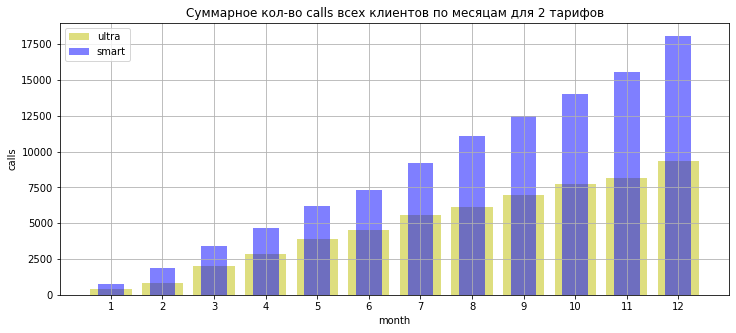

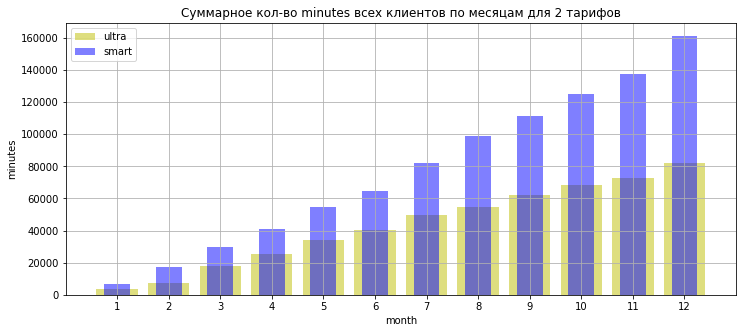

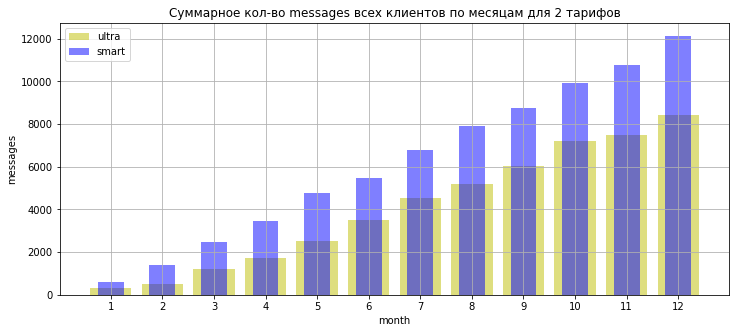

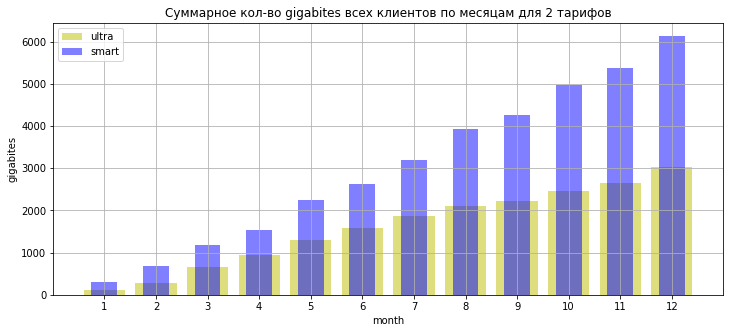

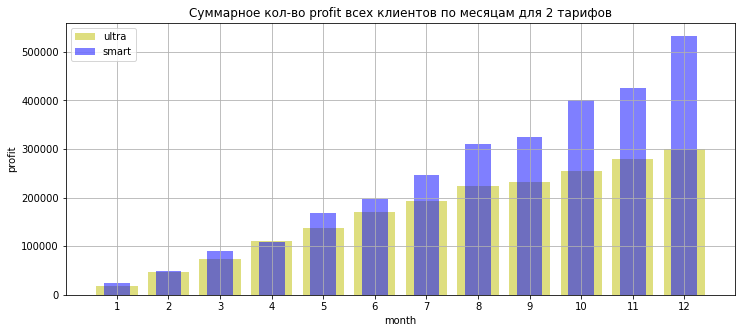

In [70]:
show_bar(union_table_sum)

In [71]:
# число уникальных пользователей
users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Суммарные значения по всем показателям в тарифе `smart` превышают значения тарифа  `ultra`. Скорее всего это связано с тем, что количество клиентов `smart` более чем в 2 раза превышает количество клиентов `ultra`. Наблюдается стабильный прирост показателей по каждому тарифу обусловленый приростом числа клиентов.

#### Средние показатели использования услуг тарифов по месяцам

Создадим обобщенную таблицу со средними ключевыми показателями


In [72]:
union_table_mean = union_table.groupby(['tariff', 'month'])[params].mean().reset_index()

В функцию построения графиков добавим отрисовку границы услуг, входящих в абонентскую плату.

In [73]:
def show_bar(df, ttl='Суммарное', params=params, smart=smart, ultra=ultra):
    """
    Функция принимает подготовленый датафрейм, делит его на выборки по тарифу (smart, ultra)
    и отрисовывает диаграммы для всех параметров в params = [...]
    Критерий ttl только для подписи диаграмм.
    Значения порога берется из словарей smart и ultra соответственно, по ключу из словаря limits.
    """
    df_smart = df.query('tariff == "smart"')
    df_ultra = df.query('tariff == "ultra"')

    limits = {'minutes': 'minutes_included',
              'messages': 'messages_included',
              'gigabites': 'gb_per_month_included',
              'profit': 'rub_monthly_fee'}

    for param in params:
        plt.figure(figsize=(12, 5),facecolor='w')
        plt.bar(df_ultra['month'], df_ultra[param], label='ultra', color='y', alpha=0.5)
        plt.bar(df_smart['month'], df_smart[param], label='smart', color='b', alpha=0.5, width=0.5)
        
        # строим пороговое значение
        if param in limits:
            plt.axhline(y=smart[limits[param]], label='Порог для smart', color='red')
#             plt.axhline(y=ultra[limits[param]], label='Порог для ultra', color='green')
        plt.grid()
#         plt.yscale('log')
        plt.xlabel('month')
        plt.ylabel(param)
        plt.xticks(range(1,13))
        plt.title(f'{ttl} кол-во {param} всех клиентов по месяцам для 2 тарифов')
        plt.legend()
        plt.show();

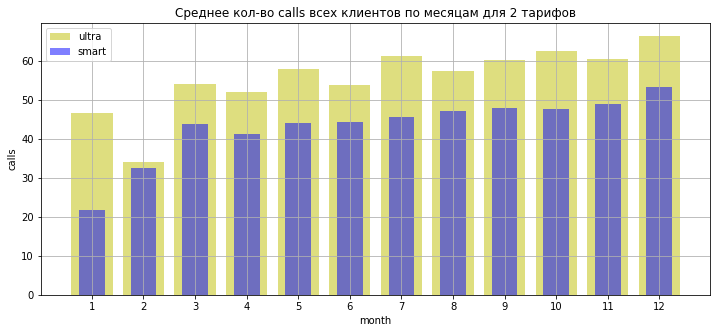

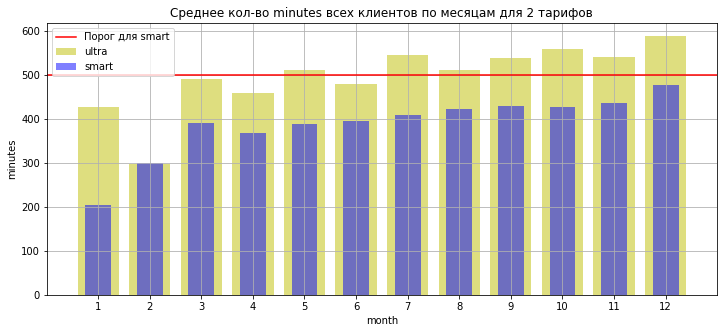

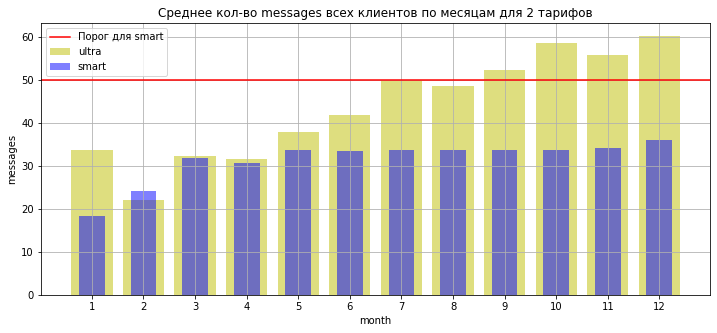

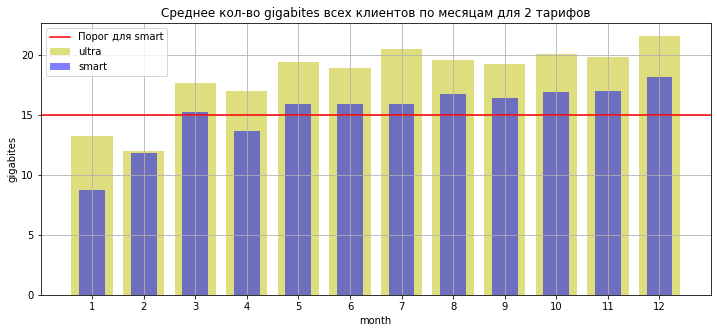

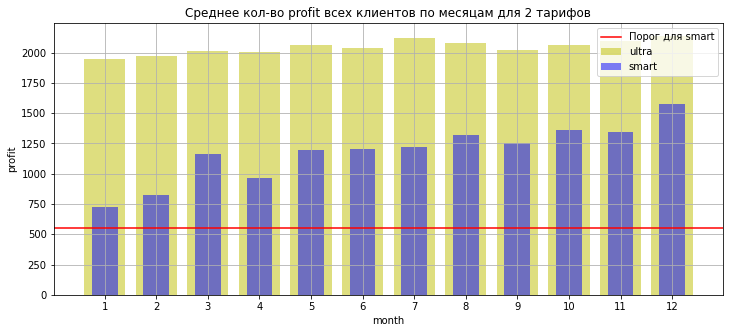

In [74]:
show_bar(union_table_mean, ttl='Среднее')

In [75]:
union_table_smart = union_table_mean.query('tariff == "smart"')
union_table_ultra = union_table_mean.query('tariff == "ultra"')

In [76]:
print('Средние значения потребленных услуг и выручка за месяц в течение 2018 года')
for param in params:
    print(f'Кол-во {param}: smart = {round(union_table_smart[param].median())} / ultra = {round(union_table_ultra[param].median())}')

Средние значения потребленных услуг и выручка за месяц в течение 2018 года
Кол-во calls: smart = 45 / ultra = 58
Кол-во minutes: smart = 402 / ultra = 511
Кол-во messages: smart = 34 / ultra = 45
Кол-во gigabites: smart = 16 / ultra = 19
Кол-во profit: smart = 1214 / ultra = 2049


По средним показателям наблюдается прямо противоположная картина. По всем показателям лидирует тариф `ultra`.
Среднее количество потраченых минут не превышает 500 для тарифа `smart` и 600 для `ultra`.
Среднее количество сообщений в месяц не превышает 35 для `smart`, и 50 для `ultra`.
И что характерно, среднее число сообщений в месяц на тарифе `smart` достигло 35 и не растет с мая. 
Так же следует отметить, что средняя выручка на тарифе `ultra` имеет незначительные колебания в течении года, тогда как на тарифе `smart` наблюдается стабильный прирост с 750 в январе до боле чем 1600 к декабрю и более чем двухкратное увеличение минут разговора в течении года. Но, не смотря на стабильный рост количества потребляемых услуг, порог превышен лишь в тарифе `smart` по использованым гигабайтам. По числу сообщений и минут разговоров клиенты не выходят за рамки тарифа. Что касается тарифа `ultra`, то там имеется значительный запас непотраченых минут (предел 3000), сообщений (предел 1000) и трафика (предел 30).

#### Нахождение значений среднего,  дисперсии и стандартного отклонения.

Для нахождения дисперсии и стандартного отклонения параметров будем использовать формулу для оценки дисперсии, учитывая, что имеем дело не с генеральной савокупностью, а выборкой. Для расчета среднего будем использовать стандартную функцию *mean*, а для дисперсии и стандартного отклонения измененные для выборки функции *var* и *std*.

In [77]:
def st_var(df):
    # вводим поправку для выборки
    return df.var(ddof=1)

def st_std(df):
    # вводим поправку для выборки
    return df.std(ddof=1)

Рассчитаем статзначения для тарифа `smart`

In [78]:
stat_table_smart = union_table.query('tariff == "smart"').\
groupby(['month'])[['minutes', 'messages', 'gigabites','profit']]\
.mean().agg(['mean', st_var, st_std]).round(1)
stat_table_smart.T

,mean,st_var,st_std
minutes,386.6,5198.3,72.1
messages,31.4,26.0,5.1
gigabites,15.2,6.9,2.6
profit,1179.7,56954.0,238.7


In [79]:
# поместим статзначения в словарь
stat_table_smart_dic = stat_table_smart.to_dict()
stat_table_smart_dic

{'minutes': {'mean': 386.6, 'st_var': 5198.3, 'st_std': 72.1},
 'messages': {'mean': 31.4, 'st_var': 26.0, 'st_std': 5.1},
 'gigabites': {'mean': 15.2, 'st_var': 6.9, 'st_std': 2.6},
 'profit': {'mean': 1179.7, 'st_var': 56954.0, 'st_std': 238.7}}

Повторим рассчет для тарифа `ultra`

In [80]:
stat_table_ultra = union_table.query('tariff == "ultra"').\
groupby(['month'])[['minutes', 'messages', 'gigabites', 'profit']]\
.mean().agg(['mean', st_var, st_std]).round(1)
stat_table_ultra.T

,mean,st_var,st_std
minutes,495.6,5925.4,77.0
messages,43.7,150.5,12.3
gigabites,18.2,8.4,2.9
profit,2046.8,3214.1,56.7


In [81]:
# поместим статзначения в словарь
stat_table_ultra_dic = stat_table_ultra.to_dict()
stat_table_ultra_dic

{'minutes': {'mean': 495.6, 'st_var': 5925.4, 'st_std': 77.0},
 'messages': {'mean': 43.7, 'st_var': 150.5, 'st_std': 12.3},
 'gigabites': {'mean': 18.2, 'st_var': 8.4, 'st_std': 2.9},
 'profit': {'mean': 2046.8, 'st_var': 3214.1, 'st_std': 56.7}}

Полученые значения будем использовать при построении гистограмм.

#### Гистограммы распределения услуг тарифов по месяцам

In [82]:
#  определим показатели для построения гистограмм
params = [ 'minutes', 'messages', 'gigabites', 'profit']


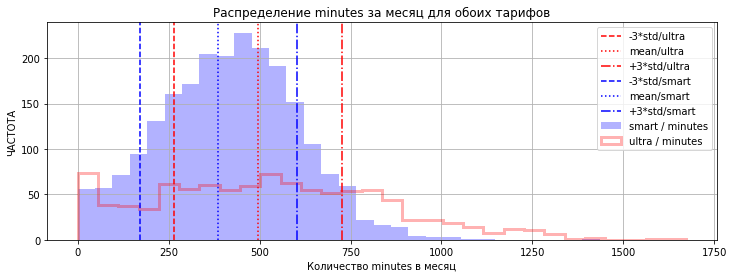

Значения для minutes


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2230.0,417.747534,190.476754,0.0,282.0,421.5,545.00,1435.0
ultra,986.0,526.089249,317.887549,0.0,282.5,518.0,751.75,1673.0


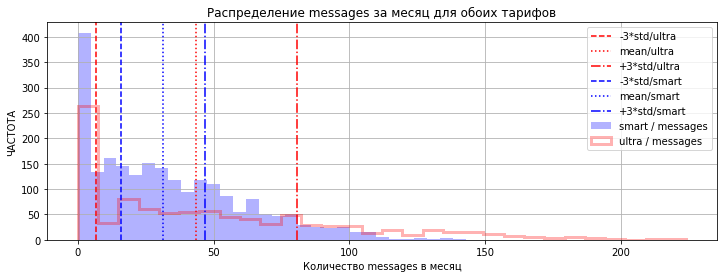

Значения для messages


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2230.0,33.369058,28.230396,0.0,10.0,28.0,51.00,143.0
ultra,986.0,49.313387,47.806040,0.0,6.0,38.0,78.75,224.0


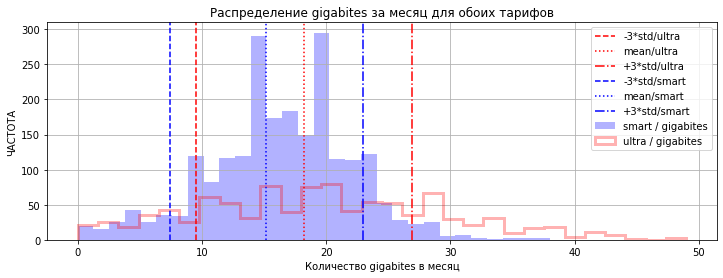

Значения для gigabites


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2230.0,16.321525,5.756167,0.0,13.0,17.0,20.0,38.0
ultra,986.0,19.474645,9.868057,0.0,12.0,19.0,27.0,49.0


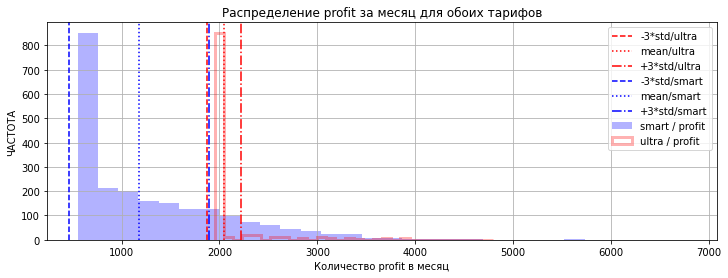

Значения для profit


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2230.0,1289.641704,818.370799,550.0,550.0,1021.0,1750.0,6770.0
ultra,986.0,2070.030426,376.015578,1950.0,1950.0,1950.0,1950.0,4800.0


In [83]:
# строим гистограммы
for param in params:
    bins = 30
    plt.figure(figsize=(12, 4))
    
    plt.hist(union_table.loc[union_table['tariff'] == "smart",  param], histtype='bar', 
             linewidth=3, label='smart / '+param, color='b', alpha=0.3, bins=bins)
    
    plt.hist(union_table.loc[union_table['tariff'] == "ultra", param], histtype='step', 
             linewidth=3, label='ultra / '+param, color='r', alpha=0.3, bins=bins)
    
    # строим пороговые значение
    if param in params:
        
        # определяем границы для ultra
        beg_ultra = stat_table_ultra_dic[param]['mean'] - 3*stat_table_ultra_dic[param]['st_std']
        end_ultra = stat_table_ultra_dic[param]['mean'] + 3*stat_table_ultra_dic[param]['st_std']
        mn_ultra = stat_table_ultra_dic[param]['mean']
        
        # строим пороговые линии для ultra
        plt.axvline(x=beg_ultra, label='-3*std/ultra', color='r', ls='--')
        plt.axvline(x=mn_ultra, label='mean/ultra', color='r', ls=':')
        plt.axvline(x=end_ultra, label='+3*std/ultra', color='r', ls='-.')
        
          # определяем границы для smart
        beg_smart = stat_table_smart_dic[param]['mean'] - 3*stat_table_smart_dic[param]['st_std']
        end_smart = stat_table_smart_dic[param]['mean'] + 3*stat_table_smart_dic[param]['st_std']
        mn_smart = stat_table_smart_dic[param]['mean']
        
        # строим пороговые линии для smart
        plt.axvline(x=beg_smart, label='-3*std/smart', color='b', ls='--')
        plt.axvline(x=mn_smart, label='mean/smart', color='b', ls=':')
        plt.axvline(x=end_smart, label='+3*std/smart', color='b', ls='-.')
        
    plt.ylabel('ЧАСТОТА')
    plt.xlabel(f'Количество {param} в месяц')
    plt.grid()
    plt.title(f'Распределение {param} за месяц для обоих тарифов')
    plt.legend()
    plt.show()
    
    # выводим сводные значения
    print(f'Значения для {param}')
    display(union_table.groupby('tariff')[param].describe())

#### Распределение клиентов по городам <a class='var'></a>

Изучим распределение потребления услуг по городам. Сгруппируем обообщенную таблицу по городам и тарифам, и посмотрим ТОП-10 городов по потреблению услуг.

In [84]:
params = ['age','calls', 'minutes', 'messages', 'gigabites', 'profit']

In [85]:
for param in params:
    df = union_table.groupby(['city','tariff'])[params].agg('mean').round(1)
    display(df.sort_values((param),ascending=False).head(10))


,,age,calls,minutes,messages,gigabites,profit
city,tariff,,,,,,
Тула,smart,72.0,49.8,455.0,33.0,18.2,1532.4
Подольск,smart,71.0,60.0,540.7,91.0,14.3,963.8
Оренбург,ultra,71.0,60.7,548.6,0.0,19.1,1950.0
Новокузнецк,ultra,69.9,37.9,325.7,122.1,14.7,1950.0
Саратов,ultra,69.0,102.5,867.5,49.0,4.5,1950.0
Пермь,ultra,68.6,55.4,503.5,20.5,20.0,1955.8
Владимир,ultra,68.0,54.5,471.5,76.0,38.5,3225.0
Ижевск,smart,67.9,60.8,522.4,50.2,17.4,1525.4
Севастополь,ultra,67.0,98.0,882.0,75.0,27.0,1950.0


,,age,calls,minutes,messages,gigabites,profit
city,tariff,,,,,,
Саратов,ultra,69.0,102.5,867.5,49.0,4.5,1950.0
Махачкала,ultra,54.0,101.5,916.8,92.0,33.2,3225.0
Кострома,ultra,28.4,101.1,896.4,45.5,23.1,2080.0
Киров,ultra,55.3,100.0,859.0,69.7,12.0,1950.0
Севастополь,ultra,67.0,98.0,882.0,75.0,27.0,1950.0
Волгоград,ultra,66.5,97.2,857.1,24.5,28.3,2335.7
Магнитогорск,ultra,54.0,92.0,842.0,91.0,28.0,1950.0
Сочи,ultra,41.0,88.7,778.8,0.0,30.8,2300.0
Барнаул,ultra,36.0,85.5,741.9,3.0,13.9,1950.0


,,age,calls,minutes,messages,gigabites,profit
city,tariff,,,,,,
Махачкала,ultra,54.0,101.5,916.8,92.0,33.2,3225.0
Кострома,ultra,28.4,101.1,896.4,45.5,23.1,2080.0
Севастополь,ultra,67.0,98.0,882.0,75.0,27.0,1950.0
Саратов,ultra,69.0,102.5,867.5,49.0,4.5,1950.0
Киров,ultra,55.3,100.0,859.0,69.7,12.0,1950.0
Волгоград,ultra,66.5,97.2,857.1,24.5,28.3,2335.7
Магнитогорск,ultra,54.0,92.0,842.0,91.0,28.0,1950.0
Сочи,ultra,41.0,88.7,778.8,0.0,30.8,2300.0
Стерлитамак,ultra,47.0,81.9,753.1,3.0,24.0,2043.8


,,age,calls,minutes,messages,gigabites,profit
city,tariff,,,,,,
Чебоксары,ultra,63.0,0.0,0.0,173.0,27.8,2100.0
Кемерово,ultra,30.0,59.8,547.5,132.0,15.8,1950.0
Новокузнецк,ultra,69.9,37.9,325.7,122.1,14.7,1950.0
Ярославль,ultra,40.0,53.3,463.7,119.0,20.6,1950.0
Сургут,ultra,55.2,58.0,551.3,110.8,15.7,1950.0
Иркутск,ultra,33.4,62.6,544.7,109.2,18.6,2062.5
Самара,ultra,36.7,59.8,529.5,95.2,14.7,2111.5
Махачкала,ultra,54.0,101.5,916.8,92.0,33.2,3225.0
Череповец,smart,38.1,64.5,571.7,91.3,18.2,2162.5


,,age,calls,minutes,messages,gigabites,profit
city,tariff,,,,,,
Владимир,ultra,68.0,54.5,471.5,76.0,38.5,3225.0
Махачкала,ultra,54.0,101.5,916.8,92.0,33.2,3225.0
Саранск,ultra,40.8,26.7,236.2,10.9,31.0,2833.3
Сочи,ultra,41.0,88.7,778.8,0.0,30.8,2300.0
Волгоград,ultra,66.5,97.2,857.1,24.5,28.3,2335.7
Магнитогорск,ultra,54.0,92.0,842.0,91.0,28.0,1950.0
Ростов-на-Дону,ultra,51.3,70.9,640.7,17.3,27.9,2512.5
Чебоксары,ultra,63.0,0.0,0.0,173.0,27.8,2100.0
Севастополь,ultra,67.0,98.0,882.0,75.0,27.0,1950.0


,,age,calls,minutes,messages,gigabites,profit
city,tariff,,,,,,
Махачкала,ultra,54.0,101.5,916.8,92.0,33.2,3225.0
Владимир,ultra,68.0,54.5,471.5,76.0,38.5,3225.0
Саранск,ultra,40.8,26.7,236.2,10.9,31.0,2833.3
Ульяновск,ultra,48.0,11.5,96.0,0.0,27.0,2625.0
Ростов-на-Дону,ultra,51.3,70.9,640.7,17.3,27.9,2512.5
Волгоград,ultra,66.5,97.2,857.1,24.5,28.3,2335.7
Красноярск,ultra,51.4,20.2,183.4,10.2,26.2,2325.0
Воронеж,ultra,39.9,76.7,691.1,78.9,25.9,2317.7
Оренбург,smart,56.0,56.8,545.2,64.0,22.8,2304.8


### Вывод


Количество совершенных в среднем звонков значительно возросло: на тарифе `smart` с 22 в январе до 54 в декабре - более чем в 2 раза, и с 46 до 66 на тарифе `ultra`. У тарифа `ultra` по всем параметрам наблюдается проседание показателей в феврале. Интересно будет узнать, что могло в компании на это повлиять.

Количество минут разговора имеет близкое к  нормальному распределению тариф `smart`, среднее 417 и медианное 421 значения очень близки, большая часть клиентов вкладывается в 500 тариффных минут. У тарифа `ultra` среднее значение 526 при медиане 518 наблюдается равномерное распределение от 0 до  900 минут, и длинный хвост почти до 1700. 3000 тарифных минут чрезвычайно избыточны.

Сообщения отправляются редко, подавляющее большинство, приходящееся на 3 квартиля, а это 75% клиентов, составляет 51 для `smart` и 78 для `ultra`, при медианных значения 28 и 38 соответственно. Средние значения тарифа `smart` не превышает 34. Лимит тарифа `ultra` также избыточен (1000 смс).

Потребление траффика - распределение похоже на нормальное, со средними значениями 16 `smart`и 19 `ultra`. Больше половины пользователей тарифа `smart` выходят за рамки лимита (15Гб) и переплачивают. В тарифе `ultra` большая часть вкладывается в лимит (30Гб).

Что касается оплаты, то очевидно, что средняя стоимость тарифа `smart` обходится клиентам почти в 2.5 раза (1289 /550)дороже абоненской платы. В тарифе `ultra` наблюдается, лишь незначительная доплата(2070/1950) к абоненской плате, при том что подавляющее большинство не выходит за ее рамки.

Любители поговорить проживают в Саратове, Махачкале и Костроме - в среднем более 100 звонков в месяц.
По числу минут лидируют Махачкала (916) и Кострома (896)  минут в среднем.
Больше 120 сообщений за месяц в Новокузнецк, Кемерово и лидирует Чебоксары (173).
В потреблении траффика лидеры Саранск, Махачкала и Владимир. Здесь имеется даже превышение лимита в 30Гб.
На эти же города приходится и максимальная оплата в месяц: Саранск -2833, Махачкала и Владимир по 3225 рублей.

## Проверка гипотез

По заданию в проекте нам необходимо, используя статистические методы проверить две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

#### Гипотеза 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Сформулируем нулевую и альтернативные гипотезы:
- $H_0$: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;
- $H_1$: средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны;

Составим множества со значениями оплатами для тарифов `ultra` и `smart`.

In [86]:
ultra_profit = union_table.query('tariff =="ultra"')['profit'].values
smart_profit = union_table.query('tariff =="smart"')['profit'].values

Сравним значения дисперсии для массивов.

In [87]:
print(f'Дисперсия для ultra_profit: {np.var(ultra_profit, ddof=1)}')
print(f'Дисперсия для smart_profit: {np.var(smart_profit, ddof=1)}')

Дисперсия для ultra_profit: 141387.7148093615
Дисперсия для smart_profit: 669730.763894807


In [88]:
# критический уровень статистической значимости
alpha = 0.05 

# дисперсии отличаются более чем в 4 раза, принимаем поправку в формуле equal_var=False
results = st.ttest_ind(ultra_profit, smart_profit, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


**Средняя выручка по тарифам**

In [89]:
# для наглядности средние выручки по тарифам Smart и Ultra
print('Средняя выручка тарифа Smart: ',smart_profit.mean().round(1))
print('Средняя выручка тарифа Ultra: ',ultra_profit.mean().round(1))


Средняя выручка тарифа Smart:  1289.6
Средняя выручка тарифа Ultra:  2070.0


Нулевую гипотезу отвергаем, т.е. вероятность получить среднее одной выборки в допустимй близости от среднего второй выборки, ничтожна мала. Причем, она на столько мала, что практически стремится к нулю. Значит делаем вывод: **Гипотеза 1 подтвердилась: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.**.

#### Гипотеза 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем нулевую и альтернативные гипотезы:
- $H_0$: средняя выручка пользователей города Москва и других городов равны;
- $H_1$: средняя выручка пользователей города Москва и других городов не равны;
Составим множества для Москвы и остальных городов

In [90]:
moscow_profit = union_table.query('city =="Москва"')['profit'].values
other_city_profit = union_table.query('city !="Москва"')['profit'].values

Сравниваем дисперсии

In [91]:
print(f'Дисперсия для moscow_profit: {np.var(moscow_profit, ddof=1)}')
print(f'Дисперсия для other_city_profit: {np.var(other_city_profit, ddof=1)}')
(print(f'Дисперсия отличаются на: \
{(np.var(other_city_profit, ddof=1) - np.var(moscow_profit, ddof=1))/np.var(other_city_profit, ddof=1)*100} %'))

Дисперсия для moscow_profit: 565636.467011886
Дисперсия для other_city_profit: 654069.5749627769
Дисперсия отличаются на: 13.520443594387284 %


In [92]:
# критический уровень статистической значимости
alpha = 0.05 

# дисперсии получились одного порядка, отличаются не более чем на 14%
# принимаем поправку в формуле equal_var=True
results = st.ttest_ind(moscow_profit, other_city_profit, equal_var=True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


Это означает, что мы не можем отвергнуть $H_0$ гипотезу, т.е. делаем вывод: **Гипотеза 2 не подтвердилась: средние выручки Москвы и других городов не отличаются.**.

**Средняя выручка по Москве и другим городам**

In [93]:
# для наглядности средние выручки по Москве и другим городам
print('Средняя выручка по Москве: ',moscow_profit.mean().round(1))
print('Средняя выручка по другим городам: ',other_city_profit.mean().round(1))


Средняя выручка по Москве:  1546.7
Средняя выручка по другим городам:  1524.7


### Вывод
Мы проверили две гипотезы и пришли к заключению:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;

## Общий вывод

В ходе проведенного исследования были получены и проанализированны исходные данные. Изучив общую информацию пришли к выводу о том, что данные поступили в корректном состоянии, не содержали критических ошибок и пропусков. Поэтому подготовка свелась к удалению незначащих столбцов, изменению типов данных.

Были расчитаны дополнительные показатели по количеству и длительности звонков, количеству отправленых сообщений, использованному траффику и выручки по месяцам на каждого клиента. Необходимые для анализа данные были собраны в общуж таблицу `union_table`.

В процессе анализа было установлено:
- среднее количество звонков выросло в течении года с 22 до 54 на тарифе `smart`, и с 46 до 66, с проседанием до 34, на тарифе `ultra`.
- средние показатели по использованым минутам также показывают стабильный рост с 200 до 480 минут на `smart`, и с 420 до 590 для `ultra`. Проседание в феврале наблюдается и здесь, и по остальным услугам. Причина? Можно уточнить у продуктовых медеджеров, какие компании, проводившиеся в это время могли на это повлиять. Лимит по минутам (500) по средним показателям не был достигнут на `smart` и тем более на `ultra` (3000), при этом более 25% пользователей `smart` попадают в диапозон 545...1435 минут. Для `ultra` этот диапозон 751...1673 минут.
- среднее количество сообщений на `smart` росло с 18 в январе до 34 в мае, и до конца года оставалось стабильным, можно предположить, что для этого тарифа это близко к  пределу, хотя 25% попадают в диапазон 51...143 сообщения. 
На `ultra` происходит стабильный рост за год с 34 до 60. Максимальное значение 224, что очень даалеко от лимита (1000).
Спрос на эту услугу невелик, четверть пользователей `smart` отправляют не более 10 сообщений в месяц, для `ultra` не более 6.
- потребление интернет-траффика на `smart`довольно интенсивно, со стабильным превышением лимита в 15Гб, начиная уже с марта и до конца года. К декабрю превышение составляет в среднем около 3Гб. Половина пользователей в диапазоне 17...28Гб. Даже среднее значение 16,3Гб превышает лимит 15Гб.
На тарифе `ultra` средние значения по месяцам 19.5Гб лимита (30Гб) не достигают.
- выручка на тарифе `ultra` в 75% состоит исключительно из абоненской платы,поскольку и по минутам и сообщениям лимит практически не расходуется. то доплаты приходит только за счет дополнительного траффика. В среднем каждый клиент потребляет срерх тариффа на 2070 - 1950 = 120 рублей(6.2%). 
Переплата каждого клиента в среднем состоит не только из траффика, но и из дополнительных минут и сообщений, и составляет 1290 - 550 = **740! рублей (135%)**.

По изложеным выше пунктам, становится ясно, что каждый пользователь тарифа `smart` в среднем приносит дополнительно 135% выручки, к тому же выручка с начала года выросла более чем в 2 раза (с 750 в январе до более 1500 в декабре. Поэтому этот тариф можно рекомендовать как основной для разработки рекламной кампании.